In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
# !pip install -U git+https://github.com/qubvel/efficientnet

In [3]:
__file__ = 'EfficientNet-B5-9.9.1-0123'
__version__ = 'v9'
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
n_gpus = len(os.environ["CUDA_VISIBLE_DEVICES"].split(','))

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from PIL import Image
import time
import efficientnet.keras as efn 

Using TensorFlow backend.


In [5]:
path_data = '../garbage_classify/train_data_v2/'
batch_size = 64
n_classes = 40
img_size = 456
img_width = img_size
img_height = img_size
random_seed = 201908
labels_file = '../tmp/labels_raw_v2.csv'

In [6]:
labels = pd.read_csv(labels_file)
labels.head()

,fname,label
0,img_14337.jpg,28
1,img_16360.jpg,32
2,img_10426.jpg,21
3,img_3370.jpg,8
4,img_10151.jpg,21


({0: 1.715303738317757,
  1: 0.9920945945945946,
  2: 1.3251805054151624,
  3: 4.369940476190476,
  4: 0.8139135254988914,
  5: 1.2745659722222222,
  6: 0.946069587628866,
  7: 1.0168282548476455,
  8: 1.0253491620111732,
  9: 0.8596604215456675,
  10: 0.9559244791666667,
  11: 0.5162798874824192,
  12: 1.1364551083591332,
  13: 0.8996936274509804,
  14: 1.0340140845070422,
  15: 0.8760739856801909,
  16: 0.9509715025906735,
  17: 1.191801948051948,
  18: 1.0084478021978023,
  19: 1.176522435897436,
  20: 1.6314444444444445,
  21: 0.5629984662576687,
  22: 0.9762632978723405,
  23: 1.1879449838187701,
  24: 1.1543238993710692,
  25: 0.6686247723132969,
  26: 1.147109375,
  27: 0.752202868852459,
  28: 0.9736737400530504,
  29: 0.8823918269230769,
  30: 1.150705329153605,
  31: 0.9041256157635468,
  32: 1.252815699658703,
  33: 1.1364551083591332,
  34: 0.9293037974683545,
  35: 1.0168282548476455,
  36: 1.6460762331838565,
  37: 1.1399844720496894,
  38: 0.9485142118863049,
  39: 0.841

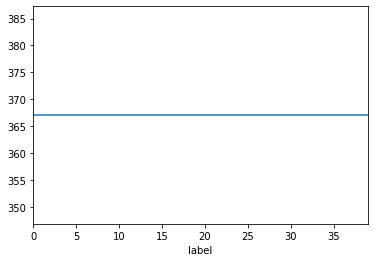

In [7]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced',  np.unique(labels.label), labels.label)
d_class_weights = dict(enumerate(class_weights))
d_class_weights,(labels.groupby(by='label').count()['fname'] * class_weights).plot()

In [8]:
n_classes

40

In [9]:
from keras.utils import np_utils, Sequence

class BaseSequence(Sequence):
    """
    基础的数据流生成器，每次迭代返回一个batch
    BaseSequence可直接用于fit_generator的generator参数
    fit_generator会将BaseSequence再次封装为一个多进程的数据流生成器
    而且能保证在多进程下的一个epoch中不会重复取相同的样本
    """

    def __init__(self, img_paths, labels, batch_size, img_size, aug, preprocess_input):
        assert len(img_paths) == len(labels), "len(img_paths) must equal to len(lables)"
        assert img_size[0] == img_size[1], "img_size[0] must equal to img_size[1]"
        self.x_y = np.hstack((np.array(img_paths).reshape(len(img_paths), 1), np.array(labels)))
        self.batch_size = batch_size
        self.img_size = img_size
        self.aug = aug
        self.preprocess_input = preprocess_input

    def __len__(self):
        return len(self.x_y) // self.batch_size

    def preprocess_img(self, img_path):
        """
        image preprocessing
        you can add your special preprocess method here
        """
        img = Image.open(img_path).convert('RGB')
        img = img.resize(self.img_size, Image.BICUBIC)
        img = np.array(img)
        # 数据增强
        if self.aug:
            datagen = ImageDataGenerator(
                width_shift_range=0.05,
                height_shift_range=0.05,
                # rotation_range=90,
                # shear_range=0.1,
                # zoom_range=0.1,
                brightness_range=(0.8, 1.3),
                horizontal_flip=True,
                vertical_flip=True)
            img = datagen.random_transform(img)
        return img

    def __getitem__(self, idx):

        batch_x = self.x_y[idx * self.batch_size: (idx + 1) * self.batch_size, 0]
        batch_y = self.x_y[idx * self.batch_size: (idx + 1) * self.batch_size, 1:]

        batch_x = np.array([self.preprocess_img(img_path) for img_path in batch_x])
        batch_y = np.array(batch_y).astype(np.float32)
        # print(batch_y[1])

        # 获取归一化数据
        batch_x = self.preprocess_input(batch_x)

        return batch_x, batch_y

    def on_epoch_end(self):
        np.random.shuffle(self.x_y)

In [10]:
train_sequence = BaseSequence(path_data + labels['fname'].values,
                              np_utils.to_categorical(labels.label.values, n_classes),
                              batch_size,
                              [img_size, img_size],
                              aug=True,
                              preprocess_input=efn.preprocess_input)

In [11]:
base_model = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3),pooling='avg')
for layer in base_model.layers[:-285]:
    layer.trainable=False

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
x = base_model.output

x = Dense(128)(x)
x = BatchNormalization()(x)
x=Dropout(0.5)(x)

DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}
predictions = Dense(n_classes, activation='softmax',kernel_initializer=DENSE_KERNEL_INITIALIZER)(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 456, 456, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 228, 228, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 228, 228, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 228, 228, 48) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

In [13]:
from keras.utils import multi_gpu_model
model = multi_gpu_model(model,gpus=4)

with open(f'../tmp/model_{__file__}.json','w') as f:
    model_json = model.to_json()
    f.write(model_json)

In [14]:
ckpt = ModelCheckpoint('../tmp/ckpt-'+__file__+'-Epoch_{epoch:03d}-acc_{acc:.5f}-loss_{loss:.5f}.h5', save_best_only=True, monitor='acc',verbose=1)

# estop = EarlyStopping(monitor='val_acc', min_delta=1e-7,verbose=1, patience=20)

reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.5,patience=1, min_lr=1e-5,verbose=1)

csv_logger = CSVLogger(f'../tmp/training_{__file__}.log',append=True)

In [ ]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
    train_sequence,
    epochs=100,
    class_weight=d_class_weights,
    callbacks=[ckpt,reduce_lr,csv_logger],
    workers=32,
    use_multiprocessing=True,
    shuffle=True
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
229/229 [==============================] - 333s 1s/step - loss: 2.0784 - acc: 0.4655

Epoch 00001: acc improved from -inf to 0.46547, saving model to ../tmp/ckpt-EfficientNet-B5-9.9.1-0123-Epoch_001-acc_0.46547-loss_2.07840.h5
Epoch 2/100
229/229 [==============================] - 243s 1s/step - loss: 0.8956 - acc: 0.7557

Epoch 00002: acc improved from 0.46547 to 0.75566, saving model to ../tmp/ckpt-EfficientNet-B5-9.9.1-0123-Epoch_002-acc_0.75566-loss_0.89556.h5
Epoch 3/100
229/229 [==============================] - 264s 1s/step - loss: 0.6410 - acc: 0.8235

Epoch 00003: acc improved from 0.75566 to 0.82349, saving model to ../tmp/ckpt-EfficientNet-B5-9.9.1-0123-Epoch_003-acc_0.82349-loss_0.64102.h5
Epoch 4/100
229/229 [==============================] - 252s 1s/step - loss: 0.5133 - acc: 0.8589

Epoch 00004: acc improved from 0.82349 to 0.85890, saving model to ../tmp/ckpt-EfficientNet-B5-9.9.1-0123-Epoch_004-acc_0.85890-los

Epoch 35/100
229/229 [==============================] - 252s 1s/step - loss: 0.0374 - acc: 0.9903

Epoch 00035: acc did not improve from 0.99120
Epoch 36/100
229/229 [==============================] - 254s 1s/step - loss: 0.0384 - acc: 0.9909

Epoch 00036: acc did not improve from 0.99120
Epoch 37/100
229/229 [==============================] - 254s 1s/step - loss: 0.0351 - acc: 0.9917

Epoch 00037: acc improved from 0.99120 to 0.99168, saving model to ../tmp/ckpt-EfficientNet-B5-9.9.1-0123-Epoch_037-acc_0.99168-loss_0.03508.h5
Epoch 38/100
229/229 [==============================] - 251s 1s/step - loss: 0.0353 - acc: 0.9931

Epoch 00038: acc improved from 0.99168 to 0.99311, saving model to ../tmp/ckpt-EfficientNet-B5-9.9.1-0123-Epoch_038-acc_0.99311-loss_0.03532.h5
Epoch 39/100
229/229 [==============================] - 252s 1s/step - loss: 0.0370 - acc: 0.9912

Epoch 00039: acc did not improve from 0.99311
Epoch 40/100
229/229 [==============================] - 254s 1s/step - loss: 0.

In [ ]:
!ls